# Pretrained Microsoft Resnet-50 Fine Tuning With Binary Classifier

### Misc Installations

In [ ]:
%pip install datasets

In [ ]:
%pip install transformers

In [ ]:
%pip install scikit-learn

In [ ]:
%pip install matplotlib

## Dataloader & Pretrained Model Import

In [ ]:
import os
import torch
from datasets_custom import get_dataloader

# =============================================================================
# Adjust these paths according to your folder structure.
# =============================================================================
if __name__ == '__main__':
    # For the train_test_easy split
    base_dir = "/Users/<USERNAME>/Downloads/ResNet-50" # REPLACE THIS WITH YOUR PROJECT FOLDER
    
    # Subfolder to the test train split CSV files:
    csv_train = os.path.join(base_dir, "TestTrainSplits", "train.csv")
    csv_test  = os.path.join(base_dir, "TestTrainSplits", "test.csv")
    
    # Directory containing JPEG images.
    images_dir = os.path.join(base_dir, "JPEGImage")
    
    # DataLoaders for training and testing.
    train_loader = get_dataloader(csv_train, images_dir, batch_size=32, train=True)
    test_loader  = get_dataloader(csv_test, images_dir, batch_size=32, train=False)
    
    # Simple test: iterate through one batch.
    for imgs, targets in test_loader:
        print("Train Images shape:", imgs.shape)  # Expected: [batch, 3, 416, 416]
        print("Train Targets:", targets)
        break

In [ ]:
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image", trust_remote_code=True)
test_image_single = dataset["test"]["image"][0]

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

In [ ]:
# Modifying pretrained model and making a test prediction

print(model.classifier) #Structure of the classifier

# Modify structure of the classifier
model.classifier = torch.nn.Sequential(
    torch.nn.Flatten(start_dim=1),
    torch.nn.Linear(model.classifier[1].in_features, 2)  #binary classification, to 2 outputs
)

# Freeze the backbone layers so we don't change those pretrained weights
for param in model.resnet.parameters():
    param.requires_grad = False


image = next(iter(test_loader))
inputs = processor(image[0], return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).tolist()

print(predicted_label)

for pred in predicted_label:
    print(pred)


## Training

Load model milestone if you are in the middle of model training:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint_path = 'trained_models/model_state_final_2.pth'

if os.path.exists(checkpoint_path):
    # Loading the save
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print("Loaded checkpoint for inference.")
else:
    print("Model not found. Failed to load")

Loaded checkpoint for inference.


/var/folders/k6/9w05dtxs7h79yh1jkg95fx700000gn/T/ipykernel_93525/3261524861.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_p

Main Training Loop:

In [ ]:
# MAIN TRAINING LOOP

# Set up directory for saving models if it doesn't exist
save_dir = 'trained_models'
os.makedirs(save_dir, exist_ok=True)

# Push to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using", device)

# Hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:

        inputs, labels = batch

        optimizer.zero_grad()

        outputs = model(pixel_values=inputs)
        logits = outputs.logits

        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        #print("batch done") #Debug Print

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss}")

    # Save model progress each epoch, in case of power loss etc
    model_path = os.path.join(save_dir, 'model_state_current.pth') # Save location for failsafe / backup milestones
    torch.save(model.state_dict(), model_path)
    print(f"Model state saved to {model_path}")

# Define the path to the file where you want to save the final model state after training
model_path = os.path.join(save_dir, 'model_state_final_3.pth')
torch.save(model.state_dict(), model_path)
print(f"Model state saved to {model_path}")

In [ ]:
# Manual code for saving the model

#save_dir = 'trained_models'
#os.makedirs(save_dir, exist_ok=True)
#model_path = os.path.join(save_dir, 'custom_save.pth')
#torch.save(model.state_dict(), model_path)
#print(f"Model state saved to {model_path}")

Unfreeze Backbone Weights: To re-create the model in the results, this should only by run in the last step

In [ ]:
for param in model.resnet.parameters():
    param.requires_grad = True

## Testing & Visualizations

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader

# Rebuild the test loader
test_loader = DataLoader(
    test_loader.dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

# ---------------------------
# Evaluation Metrics
# ---------------------------
def inference(model, test_loader):
    correct = 0
    total = 0
    model.eval()
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch

            logits = model(pixel_values=inputs).logits
            preds = logits.argmax(-1)
        
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            for i, pred in enumerate(preds):
                if pred == labels[i]:
                    if pred == 1:
                        TP += 1
                    else:
                        TN += 1
                else:
                    if pred == 1:
                        FP += 1
                    else:
                        FN += 1
                
            print("batch finished") #debug


    accuracy = correct / total
    print(f"Testing Accuracy: {accuracy}")
    print("TP:", TP)
    print("FP:", FP)
    print("TN:", TN)
    print("FN:", FN)
    print("Total:", total)
    print("Correct", correct)

# ---------------------------
# Main Inference Execution
# ---------------------------
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Assume model and test_loader are defined elsewhere.
    
    checkpoint_path = 'trained_models/model_state_final_3.pth'
    if os.path.exists(checkpoint_path):
        # Loading the saved checkpoint.
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print("Loaded checkpoint for inference.")
    else:
        print("Checkpoint not found. Using current model weights.")
    
    # Run inference and evaluation.
    inference(model, test_loader)

With 1 Epoch of training with lr=0.0001, the model has 56% accuracy.
After training another 8 Epochs with lr=0.0001, accuracy went up to 64.8% 
After training another 10 epochs with lr=0.0005, accuracy is 71%

TP = 927
TN = 1583
FP = 183
FN = 839

Correct: 2510
Total: 3532

After training another 10 epochs with lr=0.0005, accuracy is 73%
After training another 5 epochs with lr=0.0001, AFTER UNFREEZING BACKBONE WEIGHTS, accuracy is 82.9%, 0.80 F1

TP = 1197
FP = 35
TN = 1731
FN = 569

### Visualizations

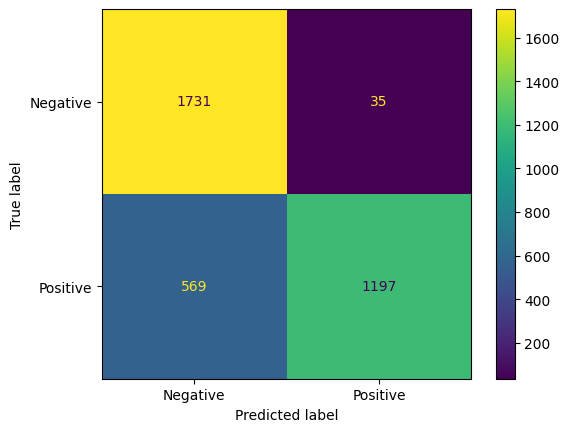

Precision: 0.9715909090909091
Recall: 0.6778029445073612
F1: 0.7985323549032688


In [ ]:
### Visualizations

import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

# Manually define confusion matrix
TP = 1197
FP = 35
TN = 1731
FN = 569

confusion_matrix = np.array([[TN, FP], [FN, TP]])

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Negative", "Positive"])

matrix.plot()
plt.show()

print("Precision:", TP/(TP+FP))
print("Recall:", TP/(TP+FN))
print("F1:", (2*TP)/((2*TP)+FP+FN))